# ConvLSTM model

Import libraries and modules.

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

C:\Users\Admin\Documents\GitHub\FLOOD_project\models
C:\Users\Admin\Documents\GitHub\FLOOD_project


In [2]:
import importlib
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

# import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.ConvLSTM_model.ConvLSTM_pytorch.multistep_convlstm import MultiStepConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from post_processing.cool_animation import plot_animation
from post_processing.plots import plot_losses

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/conv_lstm_singlelayer.pth'

Check if GPU is available.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

**Please note**: 
\
inputs and targets in <code>train_val</code> are stored not in the original manner. 

index 0 = 1, index 1 = 10, index 11 = 2, index 12 = 20 etc.

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# first position is the samples, second decides between inputs or targets, notice new shape of inputs
train_dataset[0][0].shape

torch.Size([1, 4, 64, 64])

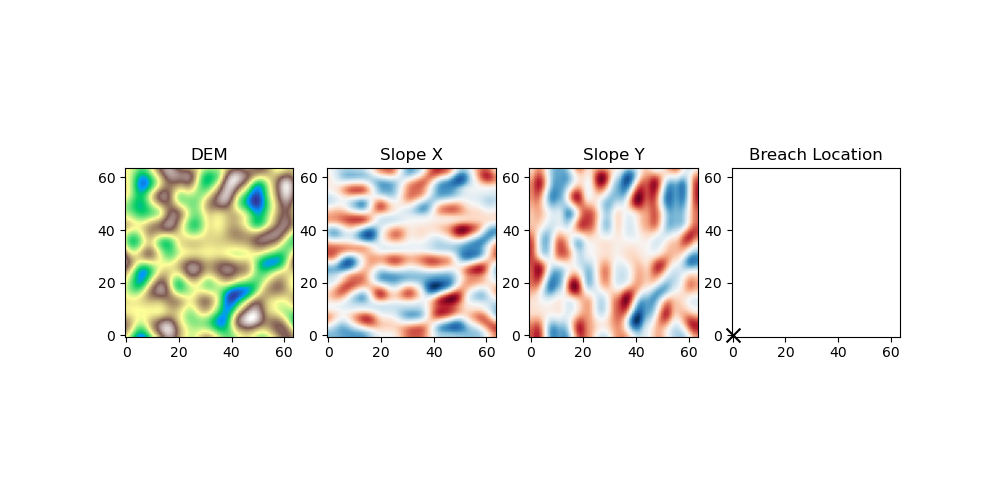

In [8]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 0
inputs = train_dataset[numb][0][0]

axs[0].imshow(inputs[0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(inputs[1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(inputs[2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

non_zero_indices = torch.nonzero(inputs[3].cpu())
non_zero_row, non_zero_col = non_zero_indices[0][0].item(), non_zero_indices[0][1].item()
axs[3].imshow(inputs[3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Breach Location')
axs[3].scatter(non_zero_col, non_zero_row, color='k', marker='x', s=100,
                clip_on = False, clip_box = plt.gca().transData)
plt.show()

In [9]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_wd, scaler_q = scaler(train_dataset)

normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_wd, scaler_q, train_val)

In [10]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(normalized_train_dataset, [train_size, val_size])

In [11]:
print(train_set[0][0].shape)

torch.Size([1, 4, 64, 64])


In [12]:
# Model
model = MultiStepConvLSTM(input_dim = train_set[0][0].shape[1], output_dim = train_set[0][1].shape[1], hidden_dim = 8, kernel_size = (3, 3),
                 num_layers = 2, batch_first=True, bias=True, return_all_layers = False).to(device)

In [13]:
model

MultiStepConvLSTM(
  (conv2): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [14]:
# Set training parameters
learning_rate = 0.0001
batch_size = 4 # Only have 64 and 16 samples for training and validation, I think should be kept small, having issues where this only works if set to 1
num_epochs = 5_000

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [15]:
train_losses = []
val_losses = []
count = 0
for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device)

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    count += 1
    if epoch%10 == 0:
        print(f"Epoch: {epoch} " +
              f"\t Training loss: {train_loss: .2e} " + 
              f"\t Validation loss: {val_loss: .2e} " +
              f"\t Best validation loss: {best_loss: .2e}")
    if count > 100:
        print(f"Loss Stagnated for 100 epochs, early stopping initiated")
        break

Epoch: 10 	 Training loss:  5.20e-03 	 Validation loss:  5.19e-03 	 Best validation loss:  5.19e-03
Epoch: 20 	 Training loss:  4.64e-03 	 Validation loss:  4.66e-03 	 Best validation loss:  4.66e-03
Epoch: 30 	 Training loss:  4.33e-03 	 Validation loss:  4.36e-03 	 Best validation loss:  4.36e-03
Epoch: 40 	 Training loss:  4.14e-03 	 Validation loss:  4.17e-03 	 Best validation loss:  4.17e-03
Epoch: 50 	 Training loss:  3.97e-03 	 Validation loss:  4.00e-03 	 Best validation loss:  4.00e-03
Epoch: 60 	 Training loss:  3.88e-03 	 Validation loss:  3.91e-03 	 Best validation loss:  3.91e-03
Epoch: 70 	 Training loss:  3.79e-03 	 Validation loss:  3.82e-03 	 Best validation loss:  3.82e-03
Epoch: 80 	 Training loss:  3.69e-03 	 Validation loss:  3.73e-03 	 Best validation loss:  3.73e-03
Epoch: 90 	 Training loss:  3.61e-03 	 Validation loss:  3.65e-03 	 Best validation loss:  3.65e-03
Epoch: 100 	 Training loss:  3.58e-03 	 Validation loss:  3.62e-03 	 Best validation loss:  3.62e-03

Epoch: 830 	 Training loss:  1.67e-03 	 Validation loss:  1.85e-03 	 Best validation loss:  1.79e-03
Epoch: 840 	 Training loss:  1.66e-03 	 Validation loss:  1.81e-03 	 Best validation loss:  1.78e-03
Epoch: 850 	 Training loss:  1.66e-03 	 Validation loss:  1.77e-03 	 Best validation loss:  1.77e-03
Epoch: 860 	 Training loss:  1.65e-03 	 Validation loss:  1.90e-03 	 Best validation loss:  1.77e-03
Epoch: 870 	 Training loss:  1.64e-03 	 Validation loss:  1.76e-03 	 Best validation loss:  1.76e-03
Epoch: 880 	 Training loss:  1.62e-03 	 Validation loss:  1.82e-03 	 Best validation loss:  1.75e-03
Epoch: 890 	 Training loss:  1.64e-03 	 Validation loss:  1.74e-03 	 Best validation loss:  1.74e-03
Epoch: 900 	 Training loss:  1.62e-03 	 Validation loss:  1.75e-03 	 Best validation loss:  1.74e-03
Epoch: 910 	 Training loss:  1.59e-03 	 Validation loss:  1.73e-03 	 Best validation loss:  1.72e-03
Epoch: 920 	 Training loss:  1.59e-03 	 Validation loss:  1.73e-03 	 Best validation loss: 

KeyboardInterrupt: 

In [16]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

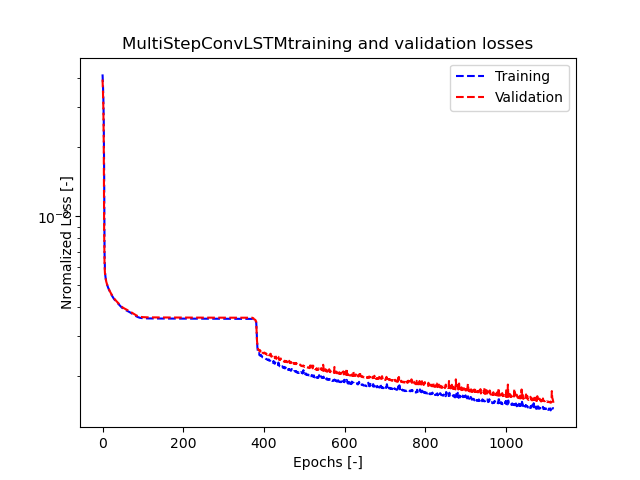

In [17]:
plot_losses(train_losses, val_losses, 'MultiStepConvLSTM')

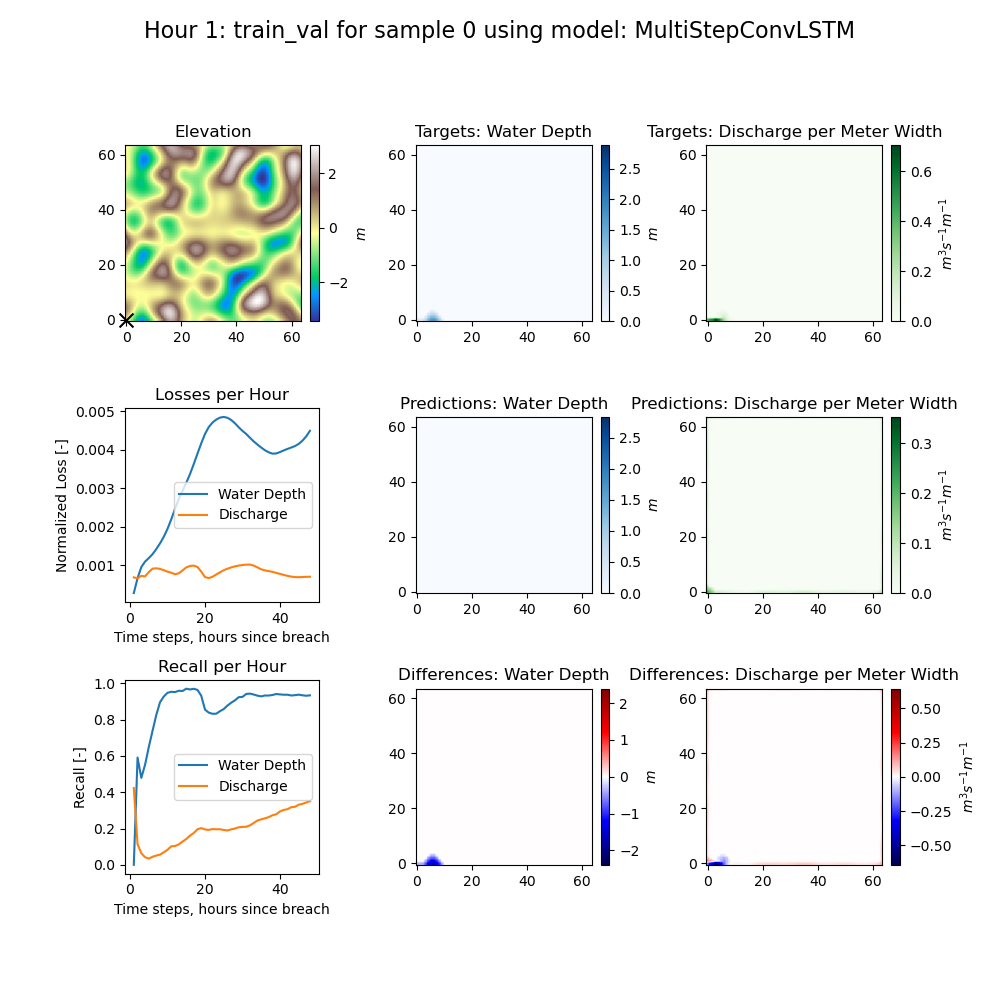

C:\Users\Admin\anaconda3\envs\dsaie\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [19]:
plot_animation(0, normalized_train_dataset, model, train_val,
               scaler_x, scaler_wd, scaler_q, device = device, save = False)